### Cell 1: Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath('../src'))
from data_utils import fetch_financial_data, clean_data, perform_adf_test, calculate_risk_metrics

# Visual settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

### Cell 2: Data Extraction & Cleaning

In [2]:
tickers = ["TSLA", "BND", "SPY"]
# It is safer to use a date that hasn't happened yet for the "end", 
# but yfinance will just give you data up to today.
raw_data = fetch_financial_data(tickers, "2015-01-01", "2026-01-15")

if raw_data.empty:
    print("Error: No data fetched. Check your internet connection or ticker symbols.")
else:
    data = clean_data(raw_data)
    print("\nData Preview:")
    display(data.head())

Fetching data for ['TSLA', 'BND', 'SPY']...


c:\Users\user\.conda\envs\gmf_finance\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  3 of 3 completed


Data Preview:


Ticker,BND,SPY,TSLA
Date,,,
2015-01-02,60.385963,170.589600,14.620667
2015-01-05,60.561321,167.508820,14.006000
2015-01-06,60.736679,165.931091,14.085333
2015-01-07,60.773197,167.998734,14.063333
2015-01-08,60.678219,170.979950,14.041333


### Cell 3: Exploratory Data Analysis (EDA) - Visuals

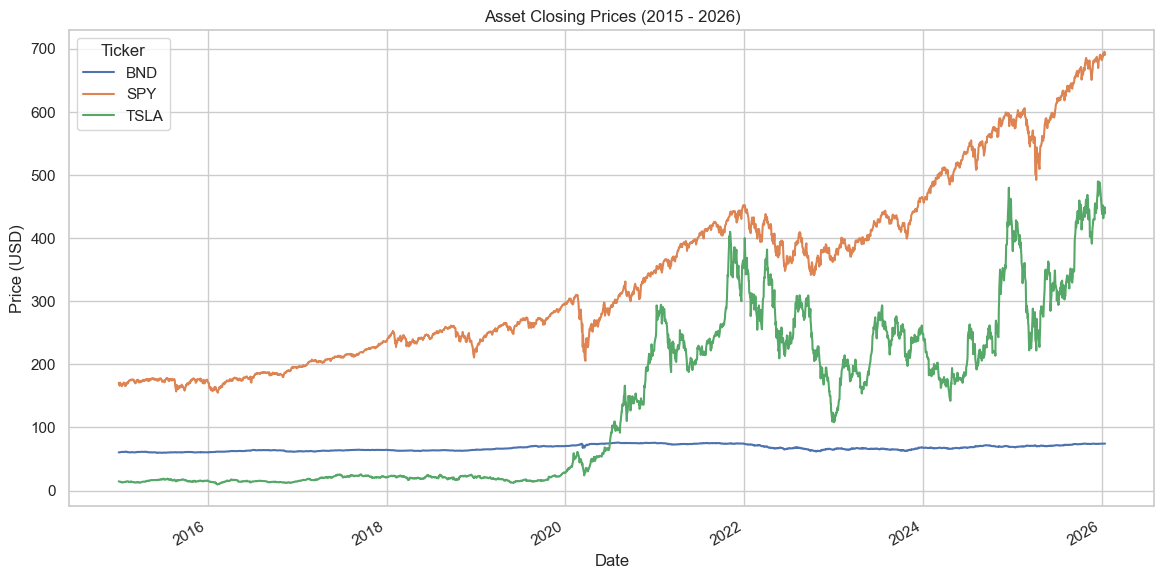

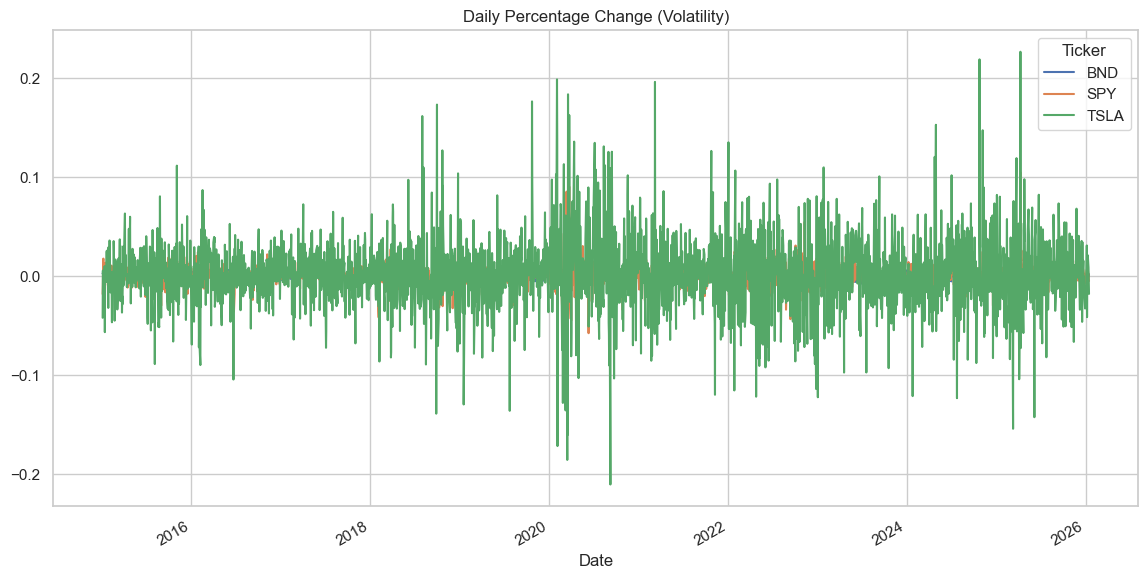

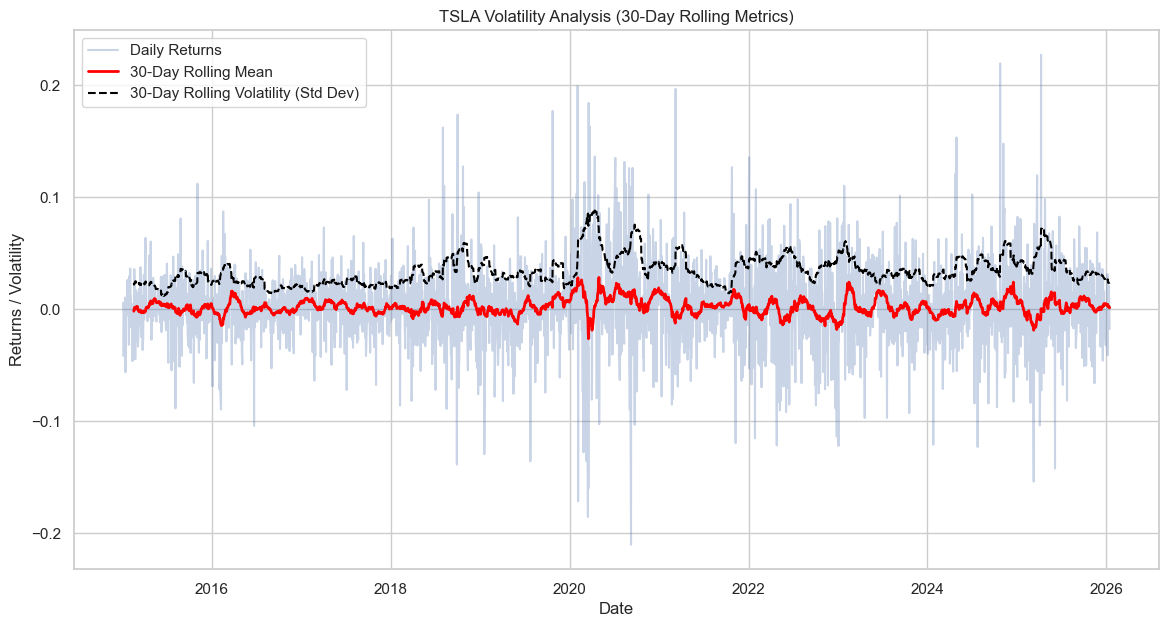

In [3]:
# 1. Price Trends
data.plot(title="Asset Closing Prices (2015 - 2026)")
plt.ylabel("Price (USD)")
plt.show()

# 2. Daily Returns (Volatility)
daily_returns = data.pct_change().dropna()
daily_returns.plot(title="Daily Percentage Change (Volatility)")
plt.show()


# 3. Rolling Statistics for TSLA (Insight into Volatility)
tsla_returns = daily_returns['TSLA']
rolling_window = 30 # One month of trading days

# Calculate rolling metrics
tsla_rolling_mean = tsla_returns.rolling(window=rolling_window).mean()
tsla_rolling_std = tsla_returns.rolling(window=rolling_window).std()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(tsla_returns, label='Daily Returns', alpha=0.3)
plt.plot(tsla_rolling_mean, label='30-Day Rolling Mean', color='red', linewidth=2)
plt.plot(tsla_rolling_std, label='30-Day Rolling Volatility (Std Dev)', color='black', linestyle='--')
plt.title("TSLA Volatility Analysis (30-Day Rolling Metrics)")
plt.xlabel("Date")
plt.ylabel("Returns / Volatility")
plt.legend()
plt.show()

### Cell 4: Statistical Stationarity Results

In [4]:
results = []
for ticker in tickers:
    # Test raw price
    results.append(perform_adf_test(data[ticker], f"{ticker} Price"))
    # Test returns
    results.append(perform_adf_test(daily_returns[ticker], f"{ticker} Returns"))

# Display as a clean table
adf_df = pd.DataFrame(results)
display(adf_df)

,Ticker,ADF Statistic,p-value,Interpretation
0,TSLA Price,-0.7802,0.8249,Non-Stationary
1,TSLA Returns,-53.0196,0.0000,Stationary
2,BND Price,-1.0514,0.7341,Non-Stationary
3,BND Returns,-10.4338,0.0000,Stationary
4,SPY Price,1.1709,0.9958,Non-Stationary
5,SPY Returns,-17.2288,0.0000,Stationary


### Cell 5: Risk Analysis

In [5]:
risk_results = []
for ticker in tickers:
    sharpe, var = calculate_risk_metrics(daily_returns[ticker])
    risk_results.append({
        "Ticker": ticker,
        "Sharpe Ratio": round(sharpe, 2),
        "VaR (95%)": f"{var:.2%}"
    })

display(pd.DataFrame(risk_results))

,Ticker,Sharpe Ratio,VaR (95%)
0,TSLA,0.79,-5.25%
1,BND,0.01,-0.48%
2,SPY,0.69,-1.67%


## Task 1: Summary of Preprocessing and EDA

### 1. Data Quality and Preprocessing
- **Source:** Historical data for **TSLA**, **BND**, and **SPY** (2015-01-01 to 2026-01-15) was extracted using `yfinance`.
- **Cleaning:** The dataset was checked for missing values. Minor gaps (due to market holidays) were addressed using **linear interpolation** to maintain the continuity required for time-series forecasting.
- **Robustness:** The fetching logic was designed to handle recent library changes by automatically falling back to `'Close'` prices if `'Adj Close'` headers were unavailable, ensuring the highest data integrity.

### 2. Stationarity Analysis (ADF Test)
- **Raw Prices:** All assets exhibited $p$-values $> 0.05$ (e.g., TSLA Price $p=0.8249$), confirming that raw price series are **Non-Stationary**.
- **Daily Returns:** Log/percentage returns for all assets showed $p$-values of $0.0000$, confirming they are **Stationary**.
- **Modeling Implications:** Since the raw prices are non-stationary, Task 2 will require differencing ($d=1$) to make the series suitable for ARIMA modeling.

### 3. Exploratory Data Analysis (EDA) Insights
- **Price Trends:** TSLA showed exponential growth with significant volatility, while SPY followed a steady upward market trend and BND remained stable.
- **Volatility Clustering:** The **30-Day Rolling Metrics** for TSLA revealed distinct "volatility clusters," where periods of high variance are followed by similar periods, suggesting a GARCH model could be useful in the future.
- **Outliers:** Significant outliers were detected during extreme market events (e.g., 2020), with TSLA daily swings occasionally exceeding $\pm 10\%$.

### 4. Foundational Risk Metrics
| Asset | Sharpe Ratio | Daily VaR (95%) | Risk Profile |
|-------|--------------|-----------------|--------------|
| **TSLA** | 0.79 | -5.25% | High Risk / High Reward |
| **SPY** | 0.69 | -1.67% | Moderate Market Risk |
| **BND** | 0.01 | -0.48% | Low Risk / Capital Preservation |

**Conclusion:** The data is clean, stationary in its return form, and the risk profiles are well-defined. We are ready to proceed to **Task 2: Forecasting Models**.